# Exploratory Data Analysis

In this notebook we will be looking at the Acquire Valued Shoppers Dataset. This dataset has 350 million transactions for more than 300k customers. The data is available at the basket-level, so each row is a single product that was bought by a given customer.

The detailed description is available at [kaggle](https://www.kaggle.com/c/acquire-valued-shoppers-challenge/data). Note that this dataset was used for another purpose (business problem) during the original kaggle competition.


### Summary

For this first exploration we will be using a random sample with 10,000 customers. The notebook has five sections:


#### 1. Overview and missing values

#### 2. Transaction quantity and amount

##### &nbsp;&nbsp;&nbsp;2.1 Univariate analysis

##### &nbsp;&nbsp;&nbsp;2.2 Timeseries analysis

##### &nbsp;&nbsp;&nbsp;2.3 Customer-aggregated values

#### 3. Categorical columns

In [104]:
#!python -m pip install --upgrade --quiet pandas
#!python -m pip install fitter

In [2]:
import io
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import boto3

def read_from_s3(bucket, filepath):
    """Read a parquet file from S3 using boto3."""
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [3]:
# Read transaction file (sample) from S3
bucket = 'capstone-transaction-data'
df = read_from_s3(bucket, 'raw_data/transactions_sample.parquet')
df.shape

(10183367, 11)

# 1. Overview and missing values

The dataset has 11 columns with the customer id, date, purchase quantity and amount, as well as informations about the product.

In [4]:
df.head(3)

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,16802992,18,97,9753,10000,0,20120309,1.0,CT,1,0.0
1,16802992,18,99,9908,102113020,15704,20120309,6.0,OZ,1,2.0
2,16802992,18,99,9908,102113020,15704,20120309,8.0,OZ,1,2.0


In [5]:
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,id,chain,dept,category,company,brand,date,productsize,purchasequantity,purchaseamount
count,10183367,10183367,10183367,10183367,10183367,10183367,10183367,10183367,10183367,10183367
mean,1853504552,126,41,4084,266625044,17306,20123819,27,2,4
std,1536070465,127,28,2839,569887752,18812,4443,50,35,6
min,16802992,2,0,0,10000,0,20120302,0,-260,-795
25%,500758630,21,17,1703,102410020,6947,20120629,7,1,2
50%,765663385,96,36,3611,104140949,12129,20121019,13,1,3
75%,3273041093,165,58,5833,107313070,18981,20130128,24,1,5
max,4809346917,526,99,9999,10999999999,108662,20130728,5000,39800,4000


Some initial insights:

- We can see some negative values for the quantity and amount.
- According to the data description, zero indicates a missing category for the dept, category and brand columns.
- Category number 10,000 represents a missing company for that product.
- Our time window is from march 2012 to august 2013.

Now let's check the number of unique categories for each column:

In [6]:
categorical = ["chain", "dept", "category", "company", "brand"]
df[categorical].nunique().to_frame().rename({0: "Unique categories"}, axis=1)

,Unique categories
chain,123
dept,83
category,826
company,19057
brand,19188


Next, the number of missing values:

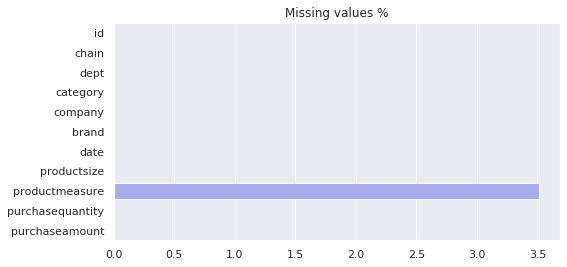

In [7]:
missing = df.isna().sum() / len(df) * 100
plt.figure(figsize=(8, 4))
_ = sns.barplot(y=missing.index, x=missing.values).set_title("Missing values %")

The only column with missing values is productmeasure. Other columns are filled with special values like zero to represent missing values. Products with missing measure also have zero size:

In [8]:
df.loc[df["productmeasure"].isna(), "productsize"].value_counts(dropna=False)

0.0    357640
Name: productsize, dtype: int64

These products are mostly from category 0 (missing value) and category 9609.

In [9]:
# Products with missing measure - % for each category (> 5%)
mask = df["productmeasure"].isna()
temp = df.loc[mask, "category"].value_counts(dropna=False, normalize=True)
temp[temp > 0.05]

0       0.521885
9609    0.461584
Name: category, dtype: float64

# 2. Transaction quantity and amount

This section will explore the purchase quantity and amount for each transaction, as well as the total values aggregated by customer and date.

## 2.1 Univariate distribution

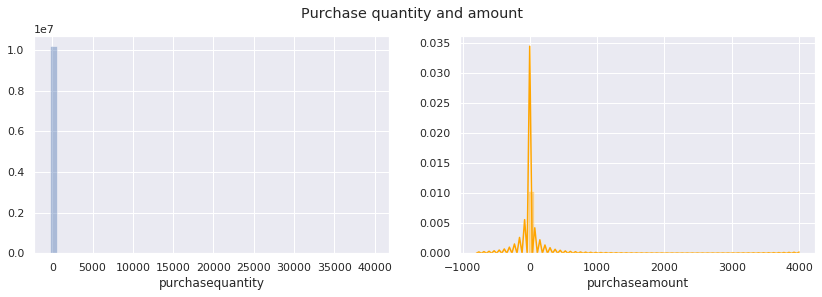

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes = axes.flatten()
fig.suptitle('Purchase quantity and amount')
sns.distplot(df.purchasequantity, ax=axes[0], kde=False)
_ = sns.distplot(df.purchaseamount, ax=axes[1], color="orange")

#### Zero and negative values - quantity and amount

Most negative values are close to zero, but we have some outliers:

Percentage of negative values in the data:
Quantity <= 0: 0.21%
Amount   <= 0: 4.12%


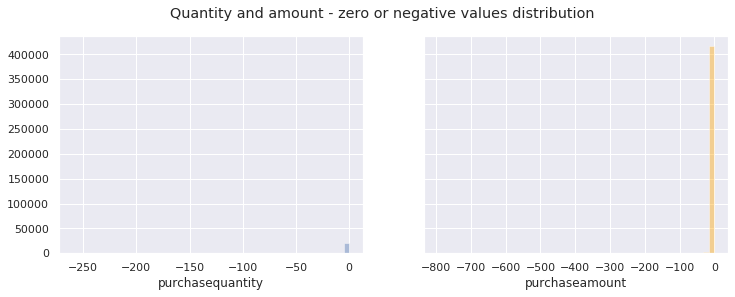

In [53]:
temp1 = df.loc[df.purchasequantity <= 0, "purchasequantity"]
temp2 = df.loc[df.purchaseamount <= 0, "purchaseamount"]
print("Percentage of negative values in the data:")
print("Quantity <= 0: {:.2f}%".format(100 * len(temp1)/len(df)))
print("Amount   <= 0: {:.2f}%".format(100 * len(temp2)/len(df)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle('Quantity and amount - zero or negative values distribution')
sns.distplot(temp1, ax=axes[0], kde=False)
_ = sns.distplot(temp2, ax=axes[1], color="orange", kde=False)

In [46]:
# print percentages for different filters
mask = (df.purchasequantity <= 0) | (df.purchaseamount <= 0)
print("Qty <= 0 or amount  <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))
mask = (df.purchasequantity <= 0) & (df.purchaseamount <= 0)
print("Qty <= 0 and amount <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))
mask = (df.purchasequantity > 0) & (df.purchaseamount <= 0)
print("Qty  > 0 and amount <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))

Qty <= 0 or amount  <= 0: 4.13%
Qty <= 0 and amount <= 0: 0.21%
Qty  > 0 and amount <= 0: 3.92%


According to the data description, a negative value for quantity and amount indicates a return. However, when considering transactions with a negative quantity OR amount, 95% of than have a positive quantity and negative amount. So for this LTR model, we will be considering any transaction with a negative amount as a return, regardless of the quantity.

## 2.2 Timeseries analysis

Now let's check the transaction quantity and amount over time (daily):

In [219]:
print("Initial date:", df.date.min(), "- last date:", df.date.max())

Initial date: 20120302 - last date: 20130728


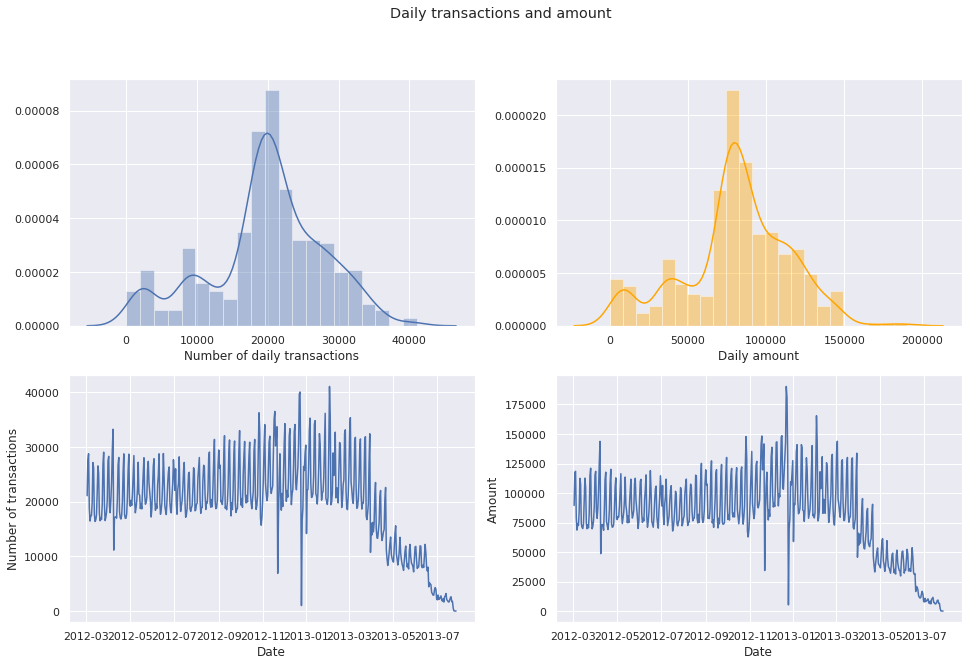

In [93]:
df["date_time"] = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)
dc = df.groupby("date_time")["purchaseamount"].count()
ds = df.groupby("date_time")["purchaseamount"].sum()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
fig.suptitle('Daily transactions and amount')
sns.distplot(dc, ax=axes[0])
sns.distplot(ds, ax=axes[1], color="orange")
sns.lineplot(x=dc.index, y=dc.values, ax=axes[2])
sns.lineplot(x=ds.index, y=ds.values, ax=axes[3])

_ = axes[0].set(xlabel='Number of daily transactions')
_ = axes[1].set(xlabel='Daily amount')
_ = axes[2].set(xlabel='Date', ylabel='Number of transactions')
_ = axes[3].set(xlabel='Date', ylabel='Amount')

There is a sharp decline in sales after march 2013 without any explanation. This is probabibly due to the data collection process. To keep the dataset consistent we will need to cut the last few months.

### Special dates

We can also see the effect of special dates like Christmas and Thanksgiving. There is a low purchase amount on these days, but a high amount a few days before (like december 22 and 23). The next plot shows the purchase amount from december 20 to january 02:

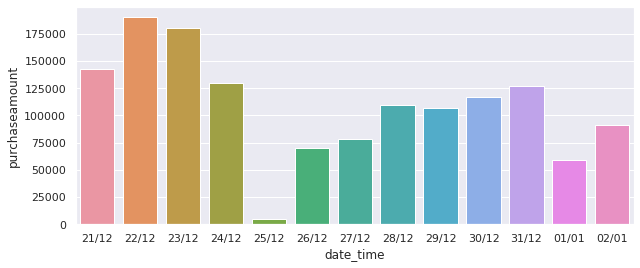

In [94]:
window = ds[(ds.index > datetime(2012, 12, 20)) & (ds.index < datetime(2013, 1, 3))]
window = window.to_frame().reset_index()

plt.figure(figsize=(10,4))
_ = sns.barplot(x=window.date_time.dt.strftime("%d/%m"), y=window.purchaseamount)

### Seasonality

There is also weekly and monthly seasonality:

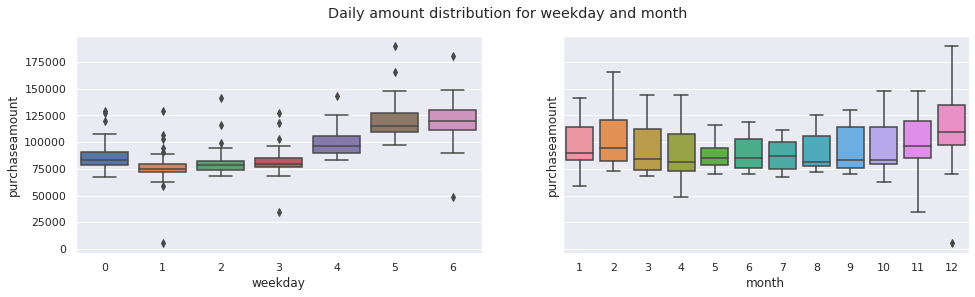

In [102]:
ds = ds[ds.index < datetime(2013, 3, 30)].to_frame().reset_index()
ds["weekday"] = ds["date_time"].dt.weekday
ds["month"] = ds["date_time"].dt.month

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
fig.suptitle('Daily amount distribution for weekday and month')
axes = axes.flatten()
_ = sns.boxplot(x="weekday", y="purchaseamount", data=ds, ax=axes[0])
_ = sns.boxplot(x="month", y="purchaseamount", data=ds, ax=axes[1])

We can see a higher demand on weekends and in december. Christmas (dec 25) is the only outlier on the right plot.

## 2.2 Customer-aggregated values

The purchase quantity and amount have a very skewed distribution since products can be quite different in price and unit. Therefore, the aggregated values at the customer level are much more useful to our problem.

The **left** plot shows the total **number of transactions** per customer, while the **right** plot shows the **number of total itens** (purchasequantity sum):

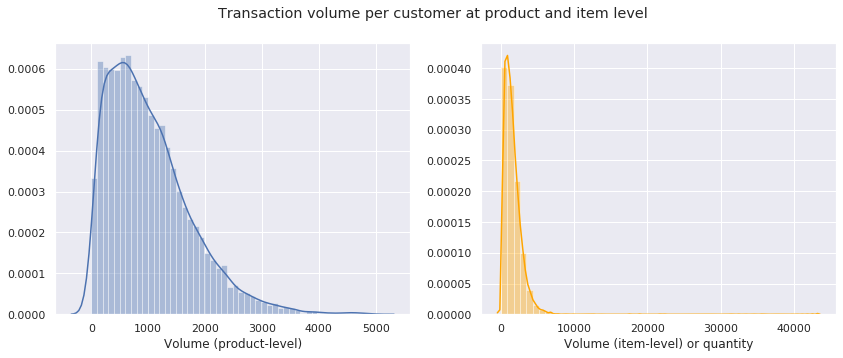

In [47]:
prod_transactions = df.groupby("id")["purchasequantity"].count()
item_transactions = df.groupby("id")["purchasequantity"].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Transaction volume per customer at product and item level')
sns.distplot(prod_transactions, ax=axes[0])
sns.distplot(item_transactions, ax=axes[1], color="orange")
_ = axes[0].set(xlabel='Volume (product-level)')
_ = axes[1].set(xlabel='Volume (item-level) or quantity')

Now the purchase amount in normal scale and log scale:

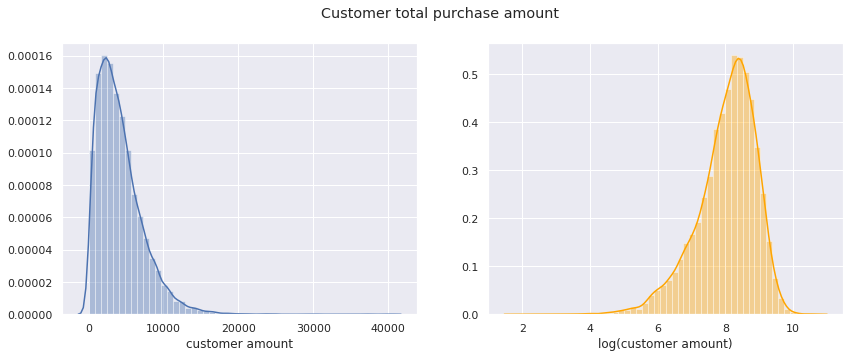

In [177]:
customer_amount = df.groupby("id")["purchaseamount"].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Customer total purchase amount')
sns.distplot(customer_amount, ax=axes[0])
sns.distplot(np.log(customer_amount), ax=axes[1], color="orange")
_ = axes[0].set(xlabel='customer amount')
_ = axes[1].set(xlabel='log(customer amount)')

In [153]:
q = customer_amount.quantile(0.995)
print("Percentile 99.5%: {:.1f}".format(q))

Percentile 99.5%: 15713.3


There are outliers with more than 40,000 dolars in purchases, however more than 99.5% are below 16,000. Since the purchase amount per customer is our main target, we can try to fit a parametric distribution to improve our model selection. The Fitter library fits many different distributions and plot those with the lowest squared error:

,sumsquare_error,aic,bic,kl_div
beta,4.564216e-09,2098.102665,-282675.540313,0.006409
gamma,8.232859e-09,2084.998987,-276814.783964,0.008589
exponnorm,3.190201e-08,2078.452754,-263335.800363,0.025571


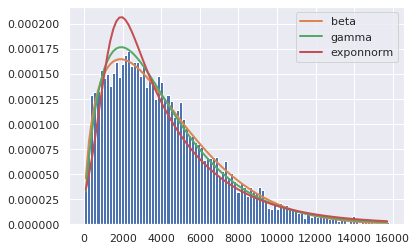

In [157]:
from fitter import Fitter
dist = ['beta', 'chi', 'chi2', 'dgamma', 'expon', 'exponnorm', 'gamma', 'norm', 't']
f = Fitter(customer_amount[customer_amount < 16000], distributions=dist)
f.fit()
f.summary(3)

The number of transactions is clearly correlated with the total purchase amount:

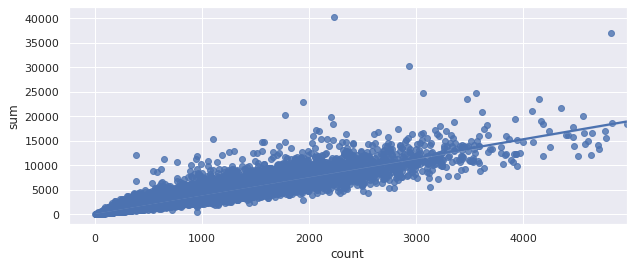

In [159]:
totals = df.groupby("id")["purchaseamount"].agg(["count", "sum"]).reset_index()
plt.figure(figsize=(10, 4))
_ = sns.regplot(x="count", y="sum", data=totals)

# 3. Categorical features

We continue our analysis with the categorical features, both at the transaction and customer level.

### Store Chain

Every customer (or each id at least) go to a single store:

In [161]:
df.groupby("id")["chain"].nunique().value_counts()

1    10000
Name: chain, dtype: int64

Number of unique values: 123


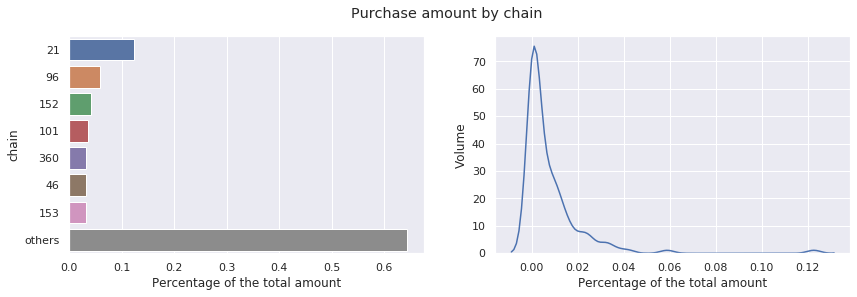

In [202]:
def categorical_analysis(column, group_threshold=0.03):
    amt = df.groupby(column)["purchaseamount"].sum() / df["purchaseamount"].sum()
    amt.sort_values(ascending=False, inplace=True)
    print("Number of unique values:", df[column].nunique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle('Purchase amount by {}'.format(column))
    
    sns.distplot(amt, hist=False, ax=axes[1])
    amt["others"] = amt[amt < group_threshold].sum()
    amt = amt[amt >= group_threshold]
    sns.barplot(y=amt.index, x=amt.values,
                ax=axes[0])

    _ = axes[0].set(xlabel='Percentage of the total amount', ylabel=column)
    _ = axes[1].set(xlabel='Percentage of the total amount', ylabel="Volume")


categorical_analysis("chain")

There are 123 store chains, but chain 21 has 12% of the total sales.

In the next plot, we can see the **average customer amount per store** distribution:

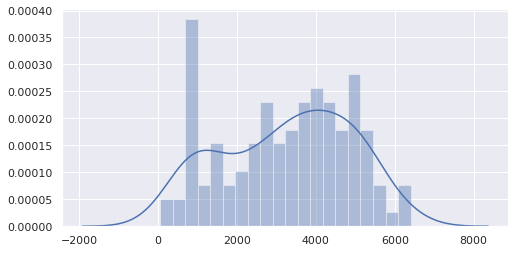

In [200]:
customer_chain = df.groupby("id")["chain"].last().to_frame().reset_index()
customer_amount = customer_amount.to_frame().reset_index()
customer_amount = customer_amount.merge(customer_chain, on="id", how="left")
avg_chain = customer_amount.groupby("chain")["purchaseamount"].mean()
plt.figure(figsize=(8, 4))
_ = sns.distplot(avg_chain.values, bins=20)

### Dept and Category

Number of unique values: 83


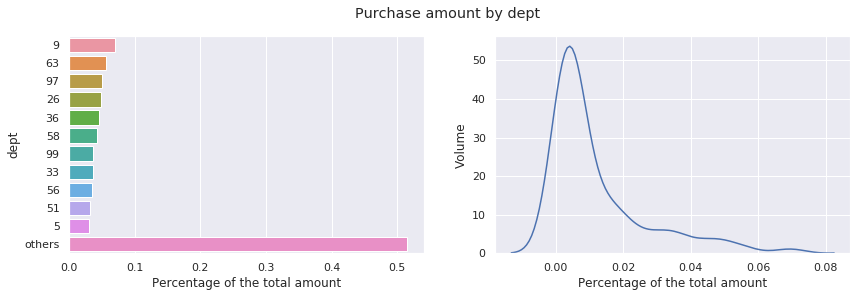

In [204]:
categorical_analysis("dept")

First two digits of the category indicates the dept.

Next, we look at the average number of different departaments and categories per customer:

In [214]:
avg_dept = df.groupby("id")["dept"].nunique().mean()
avg_categ = df.groupby("id")["category"].nunique().mean()
print("Average number of depts: {:.1f}".format(avg_dept))
print("Average number of categories: {:.1f}".format(avg_categ))

Average number of depts: 56.5
Average number of categories: 192.0


The number of depts and categories per customer is high considering that there are 83 dept and 826 categories.

### Brand and Company

Number of unique values: 19188


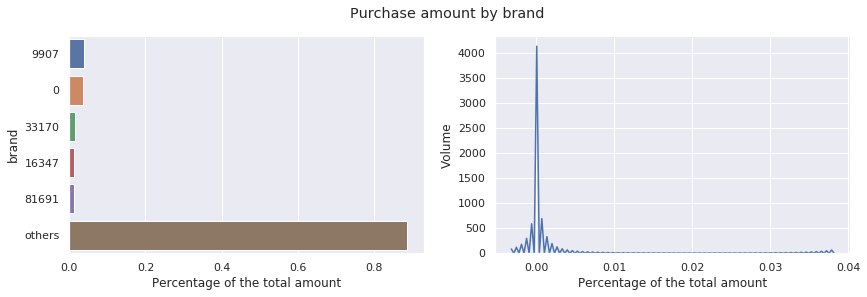

In [217]:
categorical_analysis("brand", 0.01)

Number of unique values: 19057


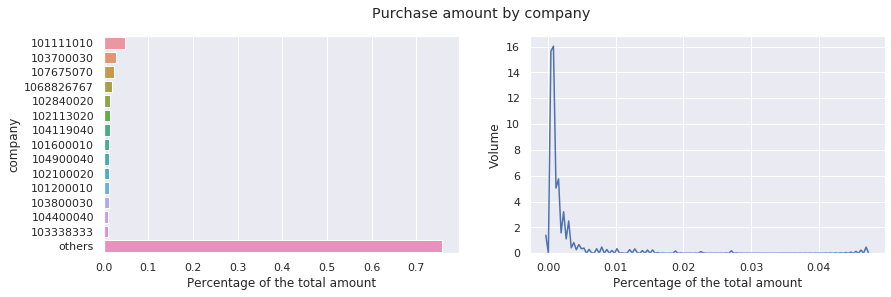

In [218]:
categorical_analysis("company", 0.01)